### 1)

chisq is  15267.937150261654  for  2501  degrees of freedom.


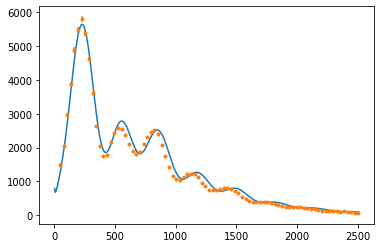

In [65]:
# Sample script

import numpy as np
import camb
from matplotlib import pyplot as plt
import time


def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]


plt.ion()

pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

chisq is  3272.2053559202204  for  2501  degrees of freedom.


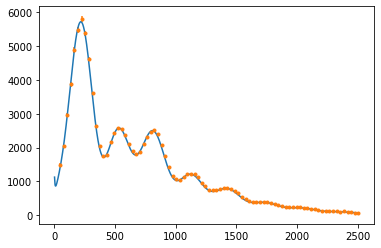

In [66]:
pars=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

In [9]:
print(3272.2/len(planck))

1.3052253689668927


For the initial parameters got a chi-squared of 15267.9 which is not a good fit as it is much higher than the degrees of freedom. Using the values given in the problem we obtain a chi-squared value of 3272.2 which is better only 1.3 times the degrees of freedom.

### 2)

In [67]:
def calc_num_der(fun,p,lendata):
    grad=np.zeros([lendata,len(p)], dtype=np.float64)
    y=fun(p)[:len(spec)]
    for i in range(len(p)):
        dx = 0.01*p[i]
        dx_array = np.zeros(np.shape(p), dtype=np.float64)
        dx_array[i] = dx
        grad[:,i]=(fun(p+dx_array)[:len(spec)] - fun(p-dx_array)[:len(spec)])/(2*dx)
    return y,grad

for j in range(6):
    pred1,grad1=calc_num_der(get_spectrum,pars,len(spec))
    chi2=sum(np.array(((pred1-spec)/errs))**2)
    r1=spec-pred1
    r1=np.matrix(r1).T
    grad1=np.matrix(grad1)
    lhs1=grad1.T@grad1
    rhs1=grad1.T@r1
    dp1=np.linalg.pinv(lhs1)@(rhs1)
    for jj in range(len(pars)):
        pars[jj]=pars[jj]+dp1[jj]
    print(pars,chi2)

[6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779231e-09 9.50000000e-01] 3272.205355920212
[6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779234e-09 9.50000000e-01] 3059.3774245345835
[6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779234e-09 9.50000000e-01] 3059.377116233408
[6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779234e-09 9.50000000e-01] 3059.377116236499
[6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779234e-09 9.50000000e-01] 3059.377116236506
[6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779234e-09 9.50000000e-01] 3059.3771162365024


In [50]:
print(pars)
par_errs=np.sqrt(np.diag(np.linalg.pinv(lhs1)))
print(par_errs)

f = open("planck_fit_params.txt", "x")
f.write('Best-fit parameters: {}\n'.format(np.array2string(pars)))
f.write('Errors in parameters: {}'.format(np.array2string(par_errs)))
f.close()

[6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779234e-09 9.50000000e-01]
[6.64718506e-26 3.69810742e-22 1.92123461e-22 9.46506613e-23
 2.24581115e-14 2.51469917e-23]


### 3)

In [ ]:
from datetime import datetime
import sys

def get_chi2(pars,y,errs):
    pred=get_spectrum(pars)[:len(y)]
    return sum(np.array(((pred-spec)/errs))**2)
    

steps=10000
chains=np.zeros([steps,len(pars)+1])
accepted=0
pars=pars+3*np.random.randn(len(pars))*par_errs
chi2=get_chi2(pars,spec,errs)
chains[0,:]=np.append(chi2,pars)
print(datetime.now().strftime("\n%H:%M:%S.%f"))
try:
    for i in range(1,steps):
        pars_new=pars+np.random.randn(len(pars))*par_errs
        chi2_new=get_chi2(pars_new,spec,errs)
        prob=np.exp(-0.5*(chi2_new-chi2))
        accept=prob>np.random.rand(1)
        if accept:
            accepted+=1
            pars=pars_new
            chi2=chi2_new
        chains[i,:]=np.append(chi2,pars)
        if i%5==0:
            print('Progress: {}% | Accepted: {}%'.format(np.round((i/steps)*100,1),np.round((accepted/i)*100),1), end="\r", flush=True)
            np.savetxt("planck_chain.txt",chains,delimiter=',')
        i+=1
except KeyboardInterrupt:
    pass
print(datetime.now().strftime("\n%H:%M:%S.%f"))


23:49:31.497687


In [ ]:
nchain=4
chains=[None]*nchain
for iter in range(nchain):
    chain=np.zeros([nstep,len(p)])
    chain[0,:]=p+3*np.random.randn(len(p))*errs
    chisq=chisq_fun(chain[0,:],x,y)
    for i in range(1,nstep):
        #take trial step
        pp=chain[i-1,:]+1.0*np.random.randn(len(errs))*errs
        chisq_new=chisq_fun(pp,x,y) #evaluate likelihood at new position
        accept=np.exp(-0.5*(chisq_new-chisq))
        if accept>np.random.rand(1):
            chain[i,:]=pp
        else:
            chain[i,:]=chain[i-1,:]
    chains[iter]=chain